In [1]:
import os
import torch
import random
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from IPython.display import Audio, display

from source.architecture import AudioClassifier
from source.data_utils import load_audio_file, load_audio_files, generate_spectrogram, generate_spectrograms
from source.eval_utils import pick_random_sample, compute_class_prototypes, evaluate_single_sample, visualize_prediction, play_audio

import config as conf

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Initialise model and load weights
checkpoint_path = "checkpoints/best_checkpoint.pth"
embedding_model = AudioClassifier(n_bands=conf.num_bands,
                                    n_frames=conf.fixed_length,
                                    n_features=conf.n_features)
embedding_model.load_state_dict(torch.load(checkpoint_path))
embedding_model.eval()

AudioClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=5120, out_features=1280, bias=True)
  (fc2a): Linear(in_features=1280, out_features=768, bias=True)
  (fc2b): Linear(in_features=768, out_features=512, bias=True)

#### CPU approach
Using the cpu and available ram to hold a large dataset (all classes, if possible) and find prediction in one step.

In [4]:
# Set the device (either 'cpu' or 'cuda')
device = "cpu"

# Support set data
support_data_folder = 'data/firearm_samples/train/'

# Load audio files and labels
support_data, support_labels, support_folders = load_audio_files(support_data_folder,
                                                conf.sr,
                                                conf.duration)

# Generate mel-spectrograms
support_data = generate_spectrograms(support_data,
                                     conf.sr,
                                     conf.n_fft,
                                     conf.n_frames)
support_labels_tensor = torch.tensor(support_labels)

# Calculate embeddings for support samples
support_embeddings = embedding_model(support_data.to(device))

# Calculate class prototypes (mean embeddings)
class_prototypes = []
available_classes = torch.unique(support_labels_tensor)
for class_label in available_classes:
    class_indices = (support_labels_tensor == class_label).nonzero(as_tuple=True)[0]
    class_embeddings = support_embeddings[class_indices]
    class_prototype = class_embeddings.mean(dim=0)
    class_prototypes.append(class_prototype)
class_prototypes = torch.stack(class_prototypes)

In [5]:
print(support_folders)

['Bersa_pistol', '1911_pistol', 'AR-15_rifle', 'M45_smg', 'Springfield_1917_rifle', 'Arisaka_rifle', 'AK_47_rifle']


In [6]:
test_sample_path = 'data/firearm_samples/test/'
class_folders = [subfolder for subfolder in os.listdir(test_sample_path) if os.path.isdir(os.path.join(test_sample_path, subfolder))]
sample_path, sample_label = pick_random_sample(test_sample_path)
# Load the sample
audio = load_audio_file(sample_path, conf.sr, conf.duration)

True label:  Springfield_1917_rifle
Predicted class:  1
Predicted label: 1911_pistol


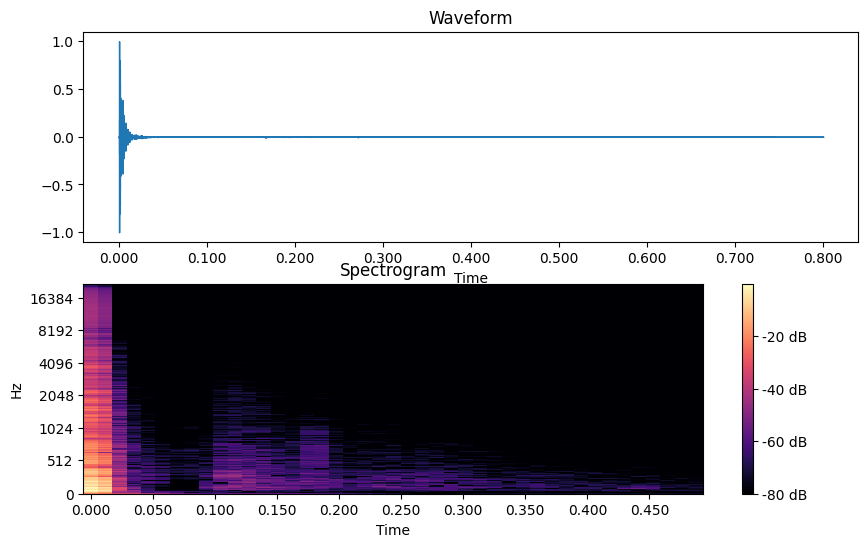

AttributeError: module 'matplotlib' has no attribute 'pyplot'

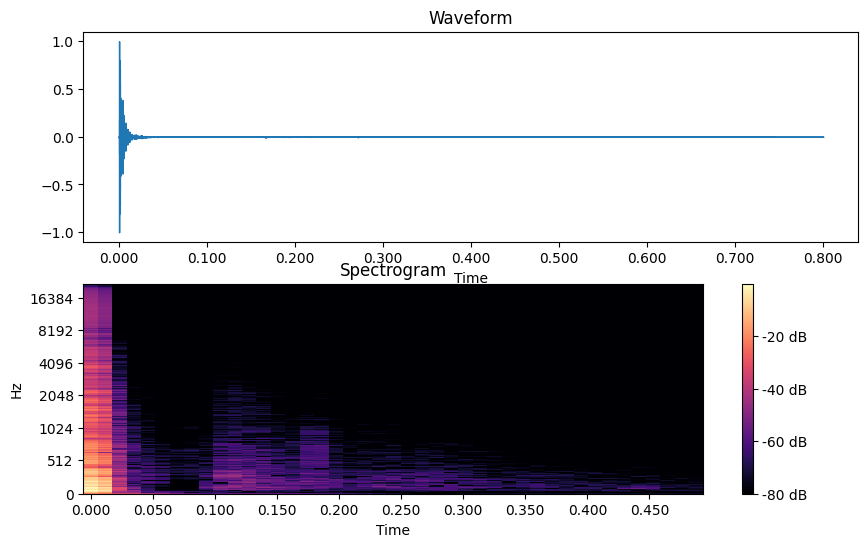

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [7]:

# Evaluate the single sample
predicted_label = evaluate_single_sample(audio,
                                         conf.sr,
                                         conf.n_fft,
                                         conf.fixed_length,
                                         embedding_model,
                                         class_prototypes,
                                         device)

print("True label: ", sample_label)
print("Predicted class: ", predicted_label)
print("Predicted label:", support_folders[predicted_label])

play_audio(audio, conf.sr)
visualize_prediction(audio, conf.sr, conf.n_fft, conf.fixed_length)